In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import curve_fit

from pydicom import dcmread

In [2]:
ds = dcmread("data/INFI.DCM")

The .DCM file contains two images corresponding to the two opposing gamma cameras in the SPETC

Each image is 512x512 pixels and has integer values corresponding to the counts in that region of space

In [3]:
# we take the data from the first gamma camera as a two dimensional array
camera = ds.pixel_array[0]

It is convinient to convert the original data to an array of weight 1 points

In [4]:
def distribution_to_points(data):
    X = []
    Y = []
    for i in range(data.shape[0]): # Y
        for j in range(data.shape[1]): # X
            value = data[i,j]
            for k in range(value):
                X.append(j)
                Y.append(i)
    assert (len(X) == len(Y) == sum(sum(data)))

    points = []
    for x,y in zip(X,Y):
        points.append([x,y])
    points = np.array(points)
    
    return points

points = distribution_to_points(camera)

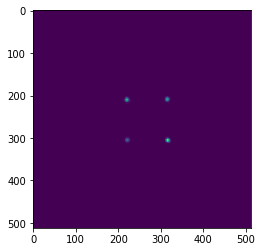

In [5]:
fig, ax = plt.subplots()
plt.imshow(camera)
plt.show()

We perform a clustering algorithm for N=4 clusters corresponding to each of the Tc99 droplets. The algorithm will give us an approximate position of each of the droplets so we can fit a distinct distribution to each one

In [6]:
from sklearn.cluster import KMeans

kmeans = KMeans(n_clusters=4)
kmeans = kmeans.fit(points)

centroids = kmeans.cluster_centers_

<IPython.core.display.Javascript object>


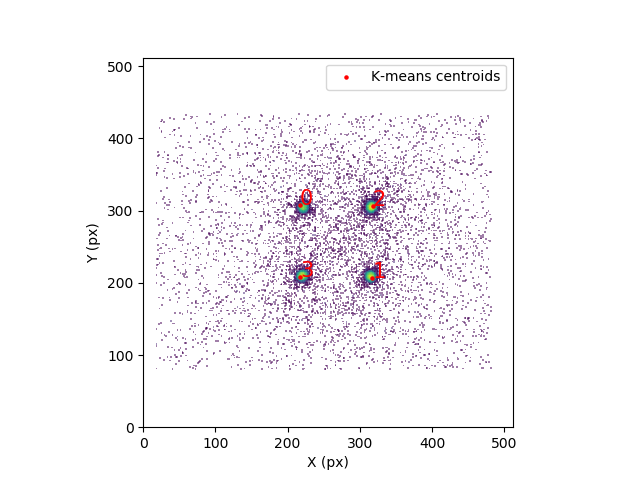

In [31]:
%matplotlib notebook

import matplotlib.colors

fig, ax = plt.subplots()

ax.hist2d(points[:,0], points[:,1], bins=range(512), norm=matplotlib.colors.LogNorm(), alpha=0.5)
ax.scatter(centroids[:, 0], centroids[:, 1], marker='o', c='r', s=5, label="K-means centroids")
for i in range(len(centroids)):
    ax.annotate(str(i), centroids[i], color="r", size=15)
    
ax.set_xlim([0,512])
ax.set_ylim([0,512])
ax.set_aspect("equal")
ax.set_xlabel("X (px)")
ax.set_ylabel("Y (px)")
ax.legend()
plt.show()

In [8]:
def get_isolated_peaks(points, centroids, radius=30):
    # radius in px
    reduction_factor = 0.9
    peak_points = [[] for i in range(len(centroids))]
    for point in points:
        n_centroids = 0 # this has to be equal to one meaning only one centroid is close enough so overlapping is prevented
        for i, centroid in enumerate(centroids):
            radial_dist = np.linalg.norm(point - centroid)
            if radial_dist <= radius:
                peak_points[i].append([point[0], point[1]])
                n_centroids += 1
        if n_centroids > 1:
            # radius is too big, abort
            print(f"radius {radius} is too big, trying with {radius*reduction_factor}")
            break
    if n_centroids > 1:
        return get_isolated_peaks(points, centroids, radius=radius*reduction_factor)
    else:
        for i in range(len(peak_points)):
            peak_points[i] = np.array(peak_points[i])
        return peak_points

In [9]:
peak_points = get_isolated_peaks(points, centroids, radius=30)

In [10]:
width = 60
peak_points = get_isolated_peaks(points, centroids, radius=width/2)
peak_hists = {i: 
             camera[int(centroids[i][1] - width/2) : int(centroids[i][1] + width/2) , int(centroids[i][0] - width/2) : int(centroids[i][0] + width/2)]
             for i in range(len(peak_points))
            }


In [20]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*numpy.exp(-(x-mu)**2/(2.*sigma**2))
def fit_gauss(x, y):
    # initial guess of coefficients is important
    mu = np.mean(x)
    sigma = 1
    A = max(y)
    p0 = [A, mu, sigma]
    coeff, var_matrix = curve_fit(gauss, x, y, p0=p0)
    
    x_fit = np.linspace(min(x),max(x),200)
    hist_fit = gauss(x_fit, *coeff)
    
    return coeff

<IPython.core.display.Javascript object>


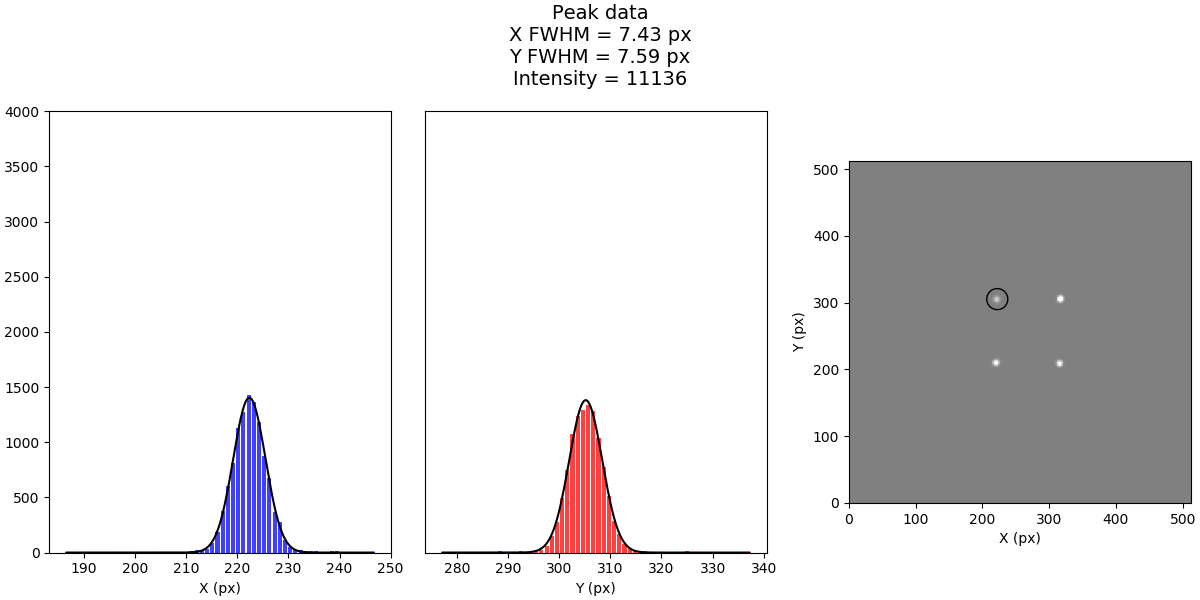

<IPython.core.display.Javascript object>


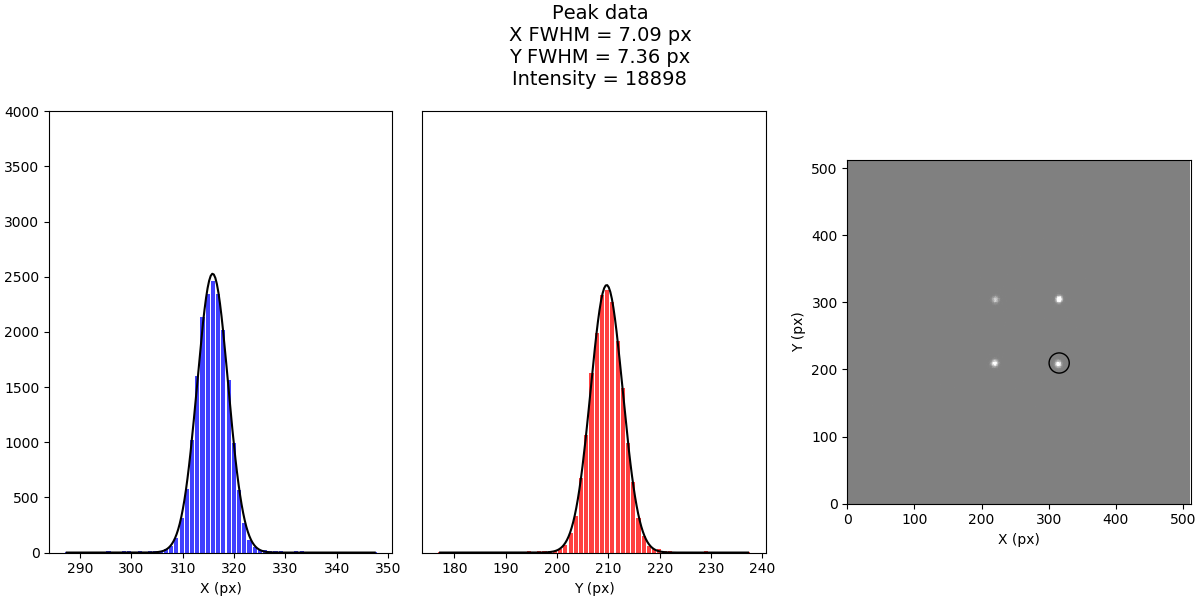

<IPython.core.display.Javascript object>


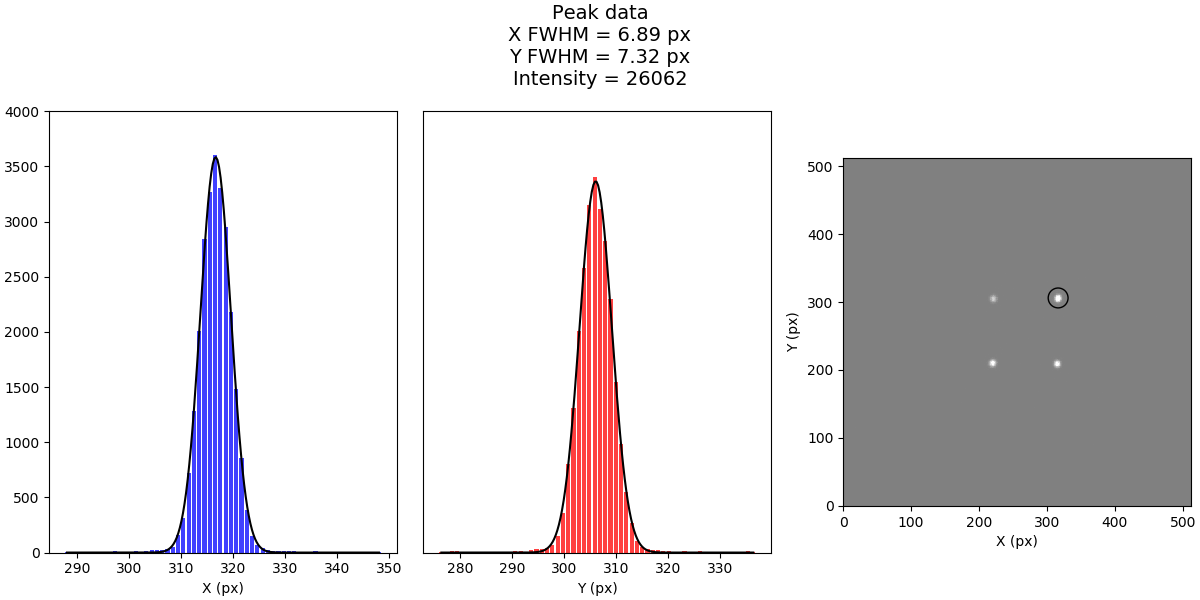

<IPython.core.display.Javascript object>


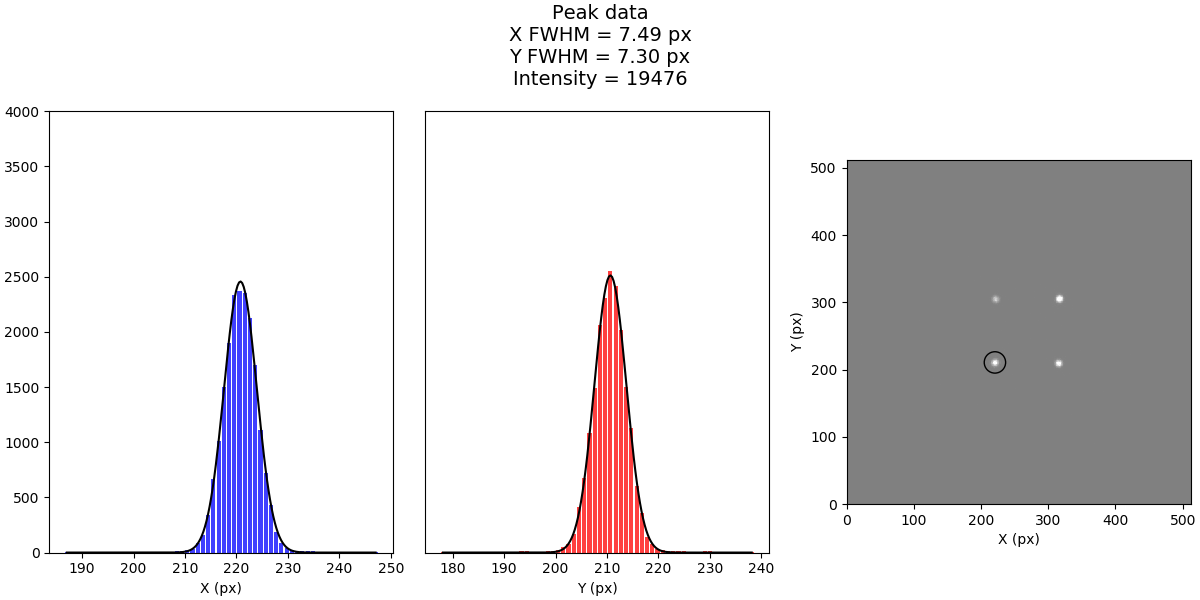

In [97]:
# first we get the maximum to have the same y axis limits in all plots
ylim_upper = 0
for i in range(len(peak_hists)):
    data = peak_hists[i]
    ylim_upper = max(max(max(data.sum(axis=0)), max(data.sum(axis=1))), ylim_upper)
ylim_upper = ylim_upper - ylim_upper % 500 + 500

for i in range(len(peak_hists)):
    centroid = centroids[i]
    data = peak_hists[i]
    
    x = np.linspace(centroid[0] - width/2, centroid[0] + width/2, width)
    data_x = data.sum(axis=0)
    x_coeff = fit_gauss(x, data_x)
    x_fit = np.linspace(min(x), max(x), 200)
    x_FWHM = 2*np.sqrt(2*np.log(2))*x_coeff[2]
    
    y = np.linspace(centroid[1] - width/2, centroid[1] + width/2, width)
    data_y = data.sum(axis=1)
    y_coeff = fit_gauss(y, data_y)
    y_fit = np.linspace(min(y), max(y), 200)
    y_FWHM = 2*np.sqrt(2*np.log(2))*y_coeff[2]
    
    fig, ax = plt.subplots(1,3, figsize=(12, 6), constrained_layout=True)

    ax[0].bar(x, data_x, color="b", alpha=0.75, label=f"FWHM = {x_FWHM:1.2f} px")
    ax[0].set_xlabel("X (px)")
    ax[0].plot(x_fit, gauss(x_fit, *x_coeff), color="black")
    
    ax[1].bar(y, data_y, color="r", alpha=0.75, label=f"FWHM = {y_FWHM:1.2f} px")
    ax[1].set_xlabel("Y (px)")
    ax[1].plot(y_fit, gauss(y_fit, *y_coeff), color="black")
    
    ax[1].set_yticks([])
    
    ax[0].set_ylim([0, ylim_upper])
    ax[1].set_ylim([0, ylim_upper])
    
    #ax[0].legend()
    #ax[1].legend()
    
    ax[2].imshow(camera, alpha=0.5, cmap='gray', vmin=0, vmax=255)
    circle = matplotlib.patches.Ellipse((x_coeff[1],y_coeff[1]), x_coeff[2]*10, x_coeff[2]*10, fill=False, color="black")
    ax[2].add_artist(circle)
    ax[2].set_xlabel("X (px)")
    ax[2].set_ylabel("Y (px)")
    ax[2].set_xlim([0, 512])
    ax[2].set_ylim([0, 512])
    #ax[2].legend()
    
    fig.suptitle(f"Peak data\nX FWHM = {x_FWHM:1.2f} px\nY FWHM = {y_FWHM:1.2f} px\nIntensity = {int(sum(data_x)):d}", fontsize=14)
    #fig.tight_layout()
    plt.savefig(f"peak_{i}.pdf")
    plt.show()

In [82]:
ds

(0008, 0000) Group Length                        UL: 452
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'STATIC', 'EMISSION']
(0008, 0016) SOP Class UID                       UI: Nuclear Medicine Image Storage
(0008, 0018) SOP Instance UID                    UI: 1.2.840.113619.2.170.1.2.0.22012020065447937.22444
(0008, 0020) Study Date                          DA: '20200122'
(0008, 0022) Acquisition Date                    DA: '20200122'
(0008, 0023) Content Date                        DA: '20200122'
(0008, 0030) Study Time                          TM: '075453'
(0008, 0032) Acquisition Time                    TM: '075453'
(0008, 0033) Content Time                        TM: '075453'
(0008, 0050) Accession Number                    SH: 'RS-03183196'
(0008, 0060) Modality                            CS: 'NM'
(0008, 0070) Manufacturer                        LO: 'GE MEDICAL SYSTEMS'
(0008, 0080) Institution Name                    LO: 'HCU LOZANO BLESA'
(0008, 

In [98]:
from PyPDF2 import PdfFileMerger

pdfs = [f"peak_{i}.pdf" for i in range(4)]

merger = PdfFileMerger()

for pdf in pdfs:
    merger.append(pdf)

merger.write("result.pdf")
merger.close()